## Determining an Unknown Players Basketball Position Using K-Nearest Neighbor Classification 

### Marcus Lam (20704185),  Elaina Qiu(94709888), Tegvir Multani (49064660), Joel Jacob (48284525)

### Introduction
In the game of basketball, there are five positions or roles that players play: Point Guard (PG), Shooting Guard (SG), Small Forward (SF), Power Forward (PF), and Center (C)
With our project, we aim to classify a given unknown player into one of these five positions using the K-Nearest Neighbor classification algorithm. 
We are using the official player statistics from the 2022-2023 NBA season as our dataset as it’s the most popular league and updated player stats. 
The dataset contains the names of all the players that played in the 2022-2023 NBA season along with their identifying information (team, age, position), and player statistics (points, rebounds, assists, blocks, steals, turnovers and shooting percentage). 



### Loading Libraries:

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

### Downloading and Reading File:

In [3]:
download.file("https://raw.githubusercontent.com/Elalalaqqq/DSCI-100-2023W2-GROUP-28/main/data/2022-2023%20NBA%20Player%20Stats%20-%20Regular.csv", "data/nbadata.csv")
nbaStats <- read_csv2("data/nbadata.csv")
nbaStats

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 679 Columns: 30
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (25): Player, Pos, Tm, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA, 2P%, eFG%, F...
dbl  (4): Rk, Age, G, GS
num  (1): MP

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,⋯,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Precious Achiuwa,C,23,TOR,55,12,207,3.6,7.3,⋯,0.702,1.8,4.1,6,0.9,0.6,0.5,1.1,1.9,9.2
2,Steven Adams,C,29,MEM,42,42,27,3.7,6.3,⋯,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
3,Bam Adebayo,C,25,MIA,75,75,346,8,14.9,⋯,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
537,Omer Yurtseven,C,24,MIA,9,0,92,1.8,3,⋯,0.833,0.9,1.7,2.6,0.2,0.2,0.2,0.4,1.8,4.4
538,Cody Zeller,C,30,MIA,15,2,145,2.5,3.9,⋯,0.686,1.7,2.6,4.3,0.7,0.2,0.3,0.9,2.2,6.5
539,Ivica Zubac,C,25,LAC,76,76,286,4.3,6.8,⋯,0.697,3.1,6.8,9.9,1,0.4,1.3,1.5,2.9,10.8


### Filter Stats For Minimum 50 Games Played
- This is to ensure that players with inflated or deflated stats because they play so less won't be taken into account

In [4]:
set.seed(2024)
filteredStats <- nbaStats |>
    group_by(Player) |>
    filter(n() == 1 | Tm == "TOT", G >= 50, !(Pos %in% c("PF-SF", "SF-SG", "SG-PG"))) |>
    ungroup() |>
    select("Pos", "FTA", "3PA", "TRB":"PTS") |>
    mutate(Pos = as.factor(case_when(Pos == "PG" | Pos == "SG" ~ "G",
                         Pos == "PF" | Pos == "SF" ~ "F",
                         Pos == "C" ~ "C")),
          across(where(is.character), as.numeric))

# Put this in mutate for 3 position classification
# Pos = as.factor(case_when(Pos == "PG" | Pos == "SG" ~ "G",
#                          Pos == "PF" | Pos == "SF" ~ "F",
#                          Pos == "C" ~ "C"))
# Put this in mutate for 5 position classification
# Pos = as.factor(Pos)


filteredStats

Pos,FTA,3PA,TRB,AST,STL,BLK,TOV,PF,PTS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C,2.3,2.0,6.0,0.9,0.6,0.5,1.1,1.9,9.2
C,5.4,0.2,9.2,3.2,1.2,0.8,2.5,2.8,20.4
G,1.2,3.9,2.1,1.1,0.3,0.3,0.7,1.7,7.9
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
F,0.5,0.6,3.1,1.4,1.0,0.1,0.8,1.6,4.4
G,8.8,6.3,3.0,10.2,1.1,0.1,4.1,1.4,26.2
C,3.1,0.0,9.9,1.0,0.4,1.3,1.5,2.9,10.8


### Get Mean For Each Position:

In [5]:
positionMean <- filteredStats |>
                group_by(Pos) |>
                summarize(count = n(), across(everything(), mean, na.rm = TRUE))
positionMean

Warning message:
“There was 1 warning in `summarize()`.
ℹ In argument: `across(everything(), mean, na.rm = TRUE)`.
ℹ In group 1: `Pos = C`.
Caused by warning:
! The `...` argument of `across()` is deprecated as of dplyr 1.1.0.
Supply arguments directly to `.fns` through an anonymous function instead.

  # Previously
  across(a:b, mean, na.rm = TRUE)

  # Now
  across(a:b, \(x) mean(x, na.rm = TRUE))”


Pos,count,FTA,3PA,TRB,AST,STL,BLK,TOV,PF,PTS
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
C,53,3.016981,1.488679,7.358491,1.949057,0.6188679,1.0358491,1.409434,2.526415,12.04528
F,112,2.257143,3.480357,4.476786,1.904464,0.6750000,0.4294643,1.183929,1.954464,11.15804
G,130,2.604615,4.610769,3.332308,3.655385,0.8823077,0.2961538,1.594615,1.870000,13.33538


### Create Mean Statistics Plot For Each Position Using pivot_longer() and facet_wrap()

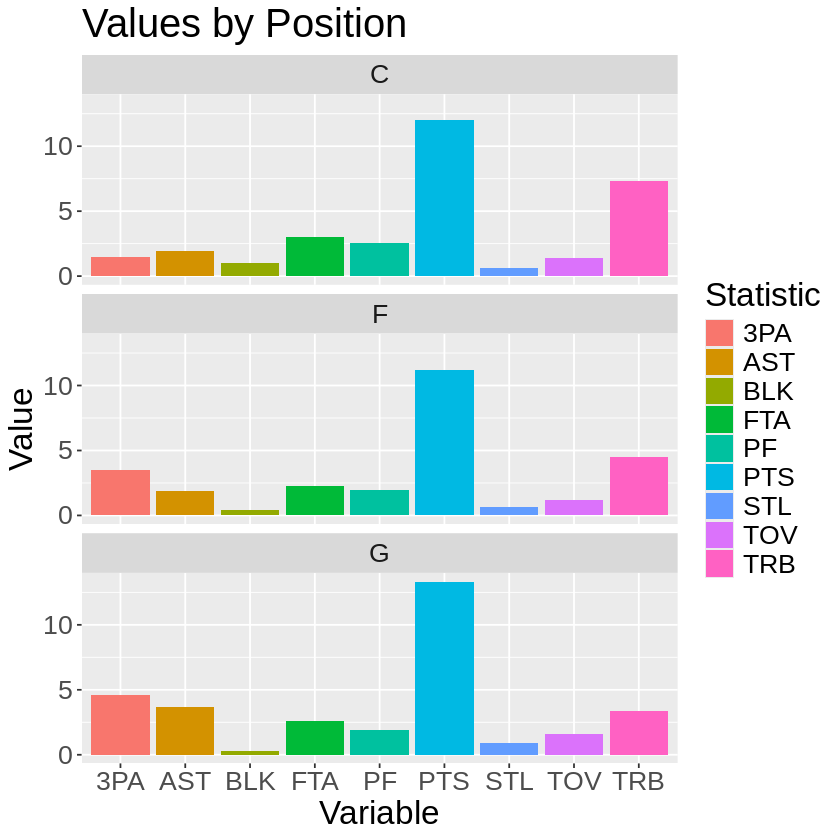

In [6]:
positionMeanLong <- positionMean |>
                    select(-count) |>
                    pivot_longer(cols = -Pos, names_to = "Variable", values_to = "Value")

positionMeanPlot <- positionMeanLong |>
                    ggplot(aes(x = Variable, y = Value, fill = Variable)) +
                    geom_bar(stat = "identity", position = "dodge") +
                    facet_wrap(~Pos, scales = "fixed", ncol = 1) +
                    labs(title = "Values by Position",
                       x = "Variable",
                       y = "Value",
                       fill = "Statistic") +
                    theme(text = element_text(size = 20))

positionMeanPlot

## Performing Data Analysis
- We will be using the k-nn algorithm to predict the position of a player based on stats.
- First, we need to select the $k$ value that has the highest accuracy in predictions. To do this we will split the data into a training set and a testing set and perform a 10-fold cross-validation on the training set.

In [7]:
set.seed(2024)

nba_split <- initial_split(filteredStats, prop = .9, strata = Pos)
nba_training <- training(nba_split)
nba_testing <- testing(nba_split)

nba_training_recipe <- recipe(Pos ~ ., data = nba_training) |> 
    step_scale(all_predictors()) |>
    step_center(all_predictors())

nba_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
	set_engine("kknn") |> 
	set_mode("classification") 

nba_vfold <- vfold_cv(nba_training, v = 10, strata = Pos)

nba_cv_results <- workflow() |>
    add_recipe(nba_training_recipe) |>
    add_model(nba_tune) |>
    tune_grid(resamples = nba_vfold, grid = tibble(neighbors = seq(2, 18, by = 1))) |>
    collect_metrics()

- Plot the accuracy vs K value to determine the best K value to use

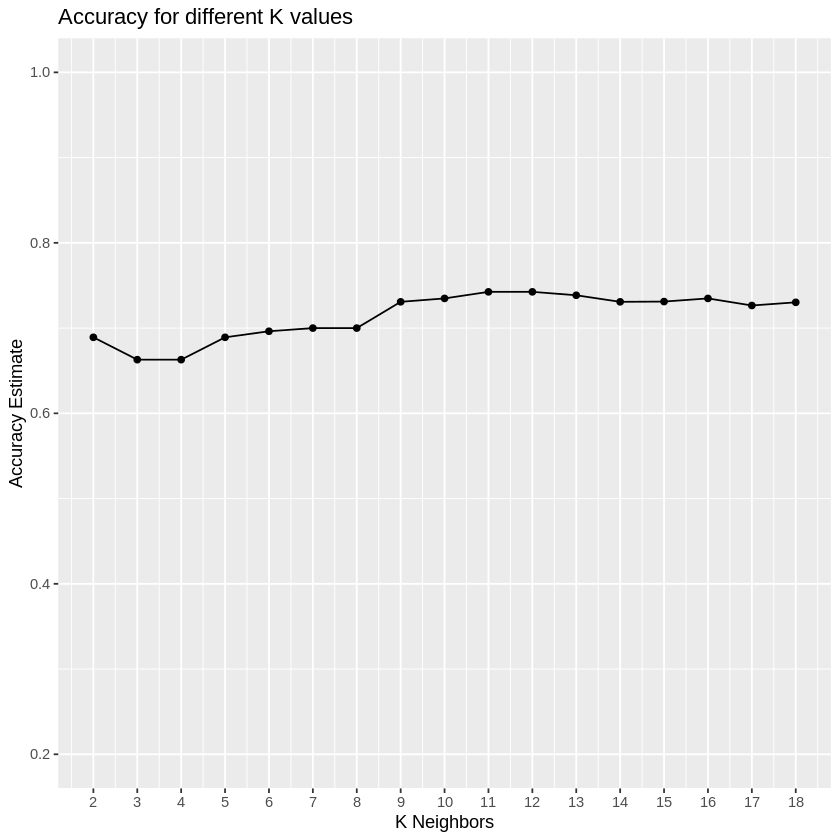

In [8]:
k_accuracy_plot <- nba_cv_results |>
    filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "K Neighbors", y = "Accuracy Estimate") +
    ggtitle("Accuracy for different K values") +
    scale_x_continuous(breaks = seq(0, 20, by = 1)) +
    scale_y_continuous(limits = c(0.2, 1.0))

k_accuracy_plot

### Building our model with K = 14

- predicting the testing set to see the accuracy.

In [13]:
set.seed(2024)

nba_spec <- nearest_neighbor(weight = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

nba_fit <- workflow() |>
    add_recipe(nba_training_recipe) |>
    add_model(nba_spec) |>
    fit(data = nba_training)

nba_test_predictions <- predict(nba_fit, nba_testing) |>
    bind_cols(nba_testing) |>
    metrics(truth = Pos, estimate = .pred_class)

nba_test_predictions 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.8387097
kap,multiclass,0.7412354
